In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

from nils.reconstruction_module import cleanup_formfactor
from nils.simulate_spectrometer_signal import get_crisp_signal

2022-02-03 14:37:14.281639: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Load and Preprocess Data

In [3]:
with open("ocelot80k.pkl", "rb") as file:
    data = pickle.load(file)

In [4]:
currents = [(sample["s"][:1000], sample["I"][:1000]) for sample in data]
del data

#### Only keep samples with current profiles that exceed 1 kA

In [5]:
filtered = [(s, current) for s, current in currents if current.max() > 1000]
len(filtered)

20335

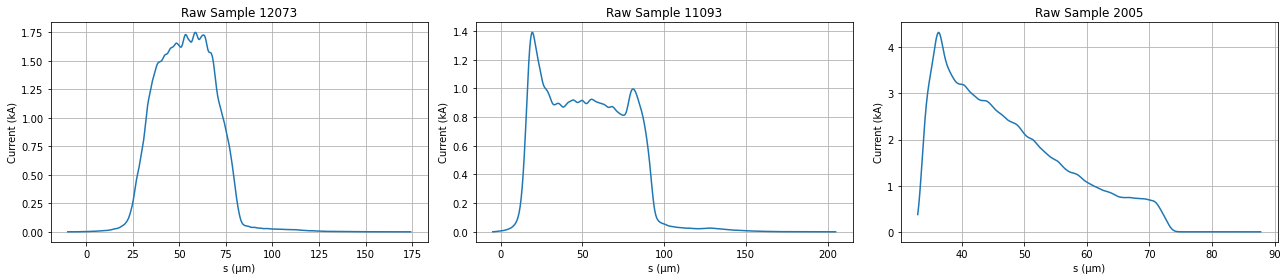

In [6]:
samples = np.random.randint(0, len(filtered), size=3)

plt.figure(figsize=(18,4))
for i, sample in enumerate(samples):
    s = filtered[sample][0]
    current = filtered[sample][1]
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Raw Sample {sample}")
    plt.plot(s*1e6, current*1e-3, label="Current")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.grid()
plt.tight_layout()
plt.show()

#### Shift center of mass of each current profile onto the origin

In [7]:
def shift_onto_center_of_mass(s, current):
    """Shift a current profile such that its center of mass it at 0."""
    cm = (s * current).sum() / current.sum()
    return s - cm, current

shifted = [shift_onto_center_of_mass(s, current) for s, current in filtered]

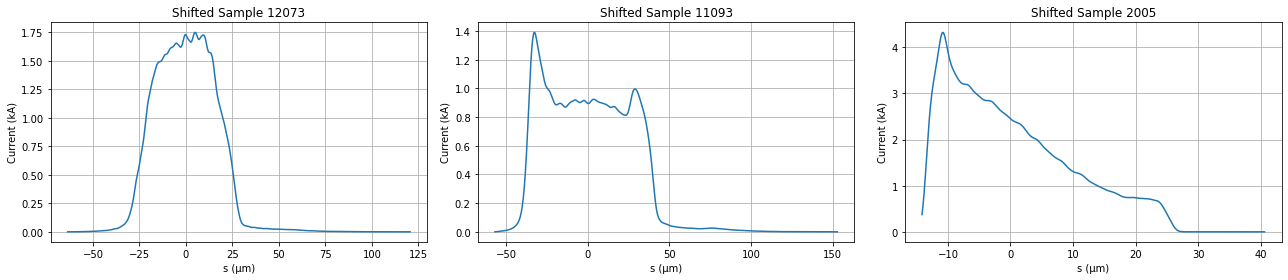

In [8]:
plt.figure(figsize=(18,4))
for i, sample in enumerate(samples):
    s = shifted[sample][0]
    current = shifted[sample][1]
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Shifted Sample {sample}")
    plt.plot(s*1e6, current*1e-3, label="Current")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.grid()
plt.tight_layout()
plt.show()

#### Interpolate all current profiles onto the same samples of *s*

In [24]:
# limit = max(max(np.abs(s)) for s, _ in shifted)
limit = 70e-6
new_s = np.linspace(-limit, limit, 100)

interpolated = [(new_s, np.interp(new_s, s, current, left=0, right=0)) for s, current in shifted]

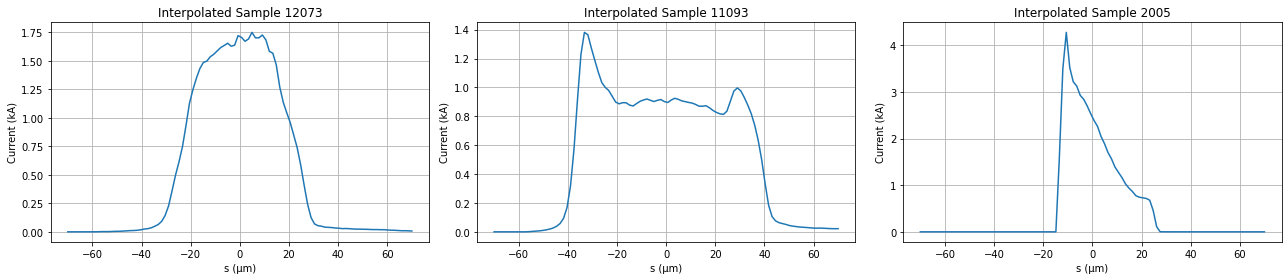

In [25]:
plt.figure(figsize=(18,4))
for i, sample in enumerate(samples):
    s = interpolated[sample][0]
    current = interpolated[sample][1]
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Interpolated Sample {sample}")
    plt.plot(s*1e6, current*1e-3, label="Current")
    plt.xlabel("s (μm)")
    plt.ylabel("Current (kA)")
    plt.grid()
plt.tight_layout()
plt.show()

#### Make formfactors

In [26]:
def current2formfactor(s, current, grating="both"):
    """Convert a current to its corresponding cleaned form factor."""
    frequency, formfactor, formfactor_noise, detlim = get_crisp_signal(s, current, n_shots=10, which_set=grating)
    clean_frequency, clean_formfactor, _ = cleanup_formfactor(frequency, formfactor, formfactor_noise, detlim, channels_to_remove=[])

    return clean_frequency, clean_formfactor

formfactors = np.array([current2formfactor(*current, grating="both") for current in filtered])

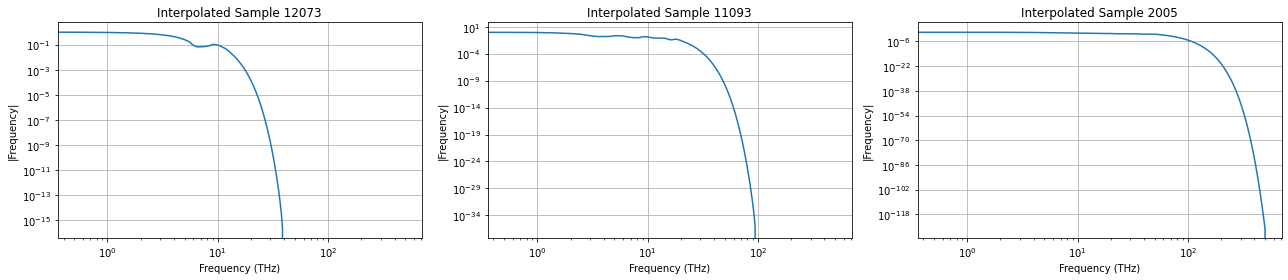

In [27]:
plt.figure(figsize=(18,4))
for i, sample in enumerate(samples):
    frequency = formfactors[sample][0]
    ff = formfactors[sample][1]
    
    plt.subplot(1, 3, i+1)
    plt.title(f"Interpolated Sample {sample}")
    plt.loglog(frequency*1e-12, ff, label="Formfactor")
    plt.xlabel("Frequency (THz)")
    plt.ylabel("|Frequency|")
    plt.grid()
plt.tight_layout()
plt.show()

## Training

In [28]:
def plot_history(history):
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.title("Loss (MSE)")
    plt.plot(history.history["loss"], label="Training")
    plt.plot(history.history["val_loss"], label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.subplot(122)
    plt.title("MAE")
    plt.plot(history.history["mae"], label="Training")
    plt.plot(history.history["val_mae"], label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

In [29]:
def evaluate_model(model, X_test, y_test, X_scaler, y_scaler):
    X_test_scaled = X_scaler.transform(X_test)
    y_test_scaled = y_test * y_scaler
    score = model.evaluate(X_test_scaled, y_test_scaled, batch_size=64)

In [30]:
def do_example_predictions(model, X_test, y_test, X_scaler, y_scaler):
    X_test_scaled = X_scaler.transform(X_test)
    y_predict_scaled = model.predict(X_test_scaled)
    y_predict = y_predict_scaled / y_scaler
    
    samples = np.random.randint(0, len(y_predict), size=3)

    plt.figure(figsize=(21,4))
    for i, sample in enumerate(samples):
        plt.subplot(1, 3, i+1)
        plt.title(f"Sample {sample}")
        plt.plot(new_s*1e6, y_test[sample]*1e-3, ls="--", label="Ground Truth")
        plt.plot(new_s*1e6, y_predict[sample]*1e-3, label="Prediction")
        plt.xlabel("s (μm)")
        plt.ylabel("Current (kA)")
        plt.legend()
        plt.grid()
    plt.show()

In [31]:
def train(formfactors, currents, epochs=500):
    """Train and return model to infer currents from formfactors."""
    X = np.stack([formfactor for _, formfactor in formfactors])
    y = np.stack([current for _, current in interpolated])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    
    X_scaler = MinMaxScaler()
    X_train_scaled = X_scaler.fit_transform(X_train)
    y_scaler = 1 / y_train.max(axis=1).mean()
    y_train_scaled = y_train * y_scaler
    
    model = keras.Sequential([
        layers.Dense(200, activation="relu"),
        layers.Dense(100, activation="relu"),
        layers.Dense(50, activation="relu"),
        layers.Dense(y_train.shape[1], activation="relu")]
    )
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    
    history = model.fit(X_train_scaled, y_train_scaled, epochs=epochs, batch_size=64, validation_split=0.25, verbose=0)
    
    plot_history(history)
    evaluate_model(model, X_test, y_test, X_scaler, y_scaler)
    do_example_predictions(model, X_test, y_test, X_scaler, y_scaler)
    
    return model, X_scaler, y_scaler

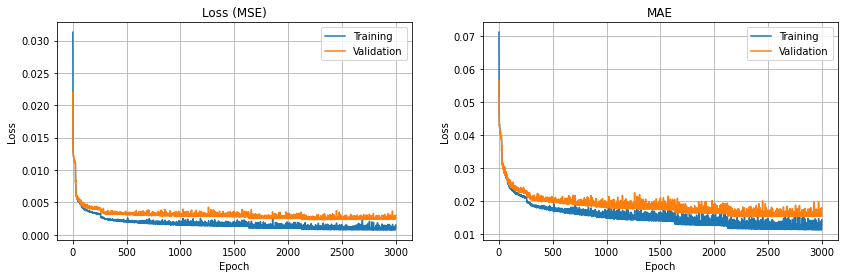

64/64 [==============================] - 0s 1ms/step - loss: 0.0032 - mae: 0.0183


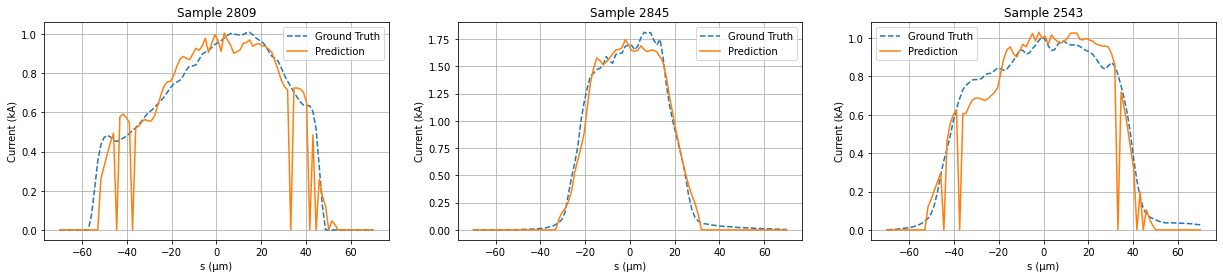

INFO:tensorflow:Assets written to: models/model/assets


In [32]:
model, X_scaler, y_scaler = train(formfactors, interpolated, epochs=3000)
model.save("models/model")
scalers = {"X": X_scaler, "y": y_scaler}
with open("models/scalers.pkl", "wb") as f:
    pickle.dump(scalers, f)